# DLNN - Deep Learning Neural Networks - Group 9

DLNN project for the Deep Learning Neural Networks course of the 2022 Postgraduate Program in Enterprise Data Science & Analytics of NOVA IMS

* Download the dataset from https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
* To run with google_colabs
    * Open the main_1.ipynb and change the variable "import_files_from_google_colab" to TRUE
    * Load the images folder to google drive in a zip file called "Faces.zip" 
* To run on your machine:
    * Open the main_1.ipynb and double check that the variable "import_files_from_google_colab" is FALSE
    * Place the images folders inside the "input" folder (you my need to create this one manually)

#### NOTE: 

The functions that take a long time to run are commented on this final version of the notebook. To run all the training and analyzes carried out, it is necessary to uncomment them. In this version the notebook runs completely in a few seconds.

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout,Flatten, Conv2D,MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import layers, initializers, regularizers, optimizers, metrics
from sklearn.utils.class_weight import compute_class_weight

# !pip install keras_tuner --upgrade 
import keras_tuner
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

import os
import time
import random 
import zipfile
import glob
from shutil import copyfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
from matplotlib.colors import ListedColormap
from matplotlib.ticker import StrMethodFormatter

from sklearn.metrics import confusion_matrix
import itertools 

from tensorflow.keras import tensorboard

## Constants

In [2]:
global_seed=1234
models_folder = 'models/'

## Source data

#### Settings

In [3]:
#definitions

import_files_from_google_colab = False

root_path = "input/"
main_folder_name, training_folder_name, testing_folder_name = "images/", "train/", "validation/"

images_size = 48


#### Import files

In [4]:
# importing files from google colab if needed
if import_files_from_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    # Set connection string
    path = "/content/drive/MyDrive/"
    # Measure time
    t0 = time.time()
    # Transfer zip dataset to the current virtual machine
    copyfile(path + 'Faces.zip', 'Faces.zip')
    # Extract files
    zip_file = zipfile.ZipFile('Faces.zip')
    zip_file.extractall()
    zip_file.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    root_path = "/content/"

In [5]:
base_path = root_path + main_folder_name
training_folder = base_path + training_folder_name
testing_folder = base_path + testing_folder_name

#### Show samples images

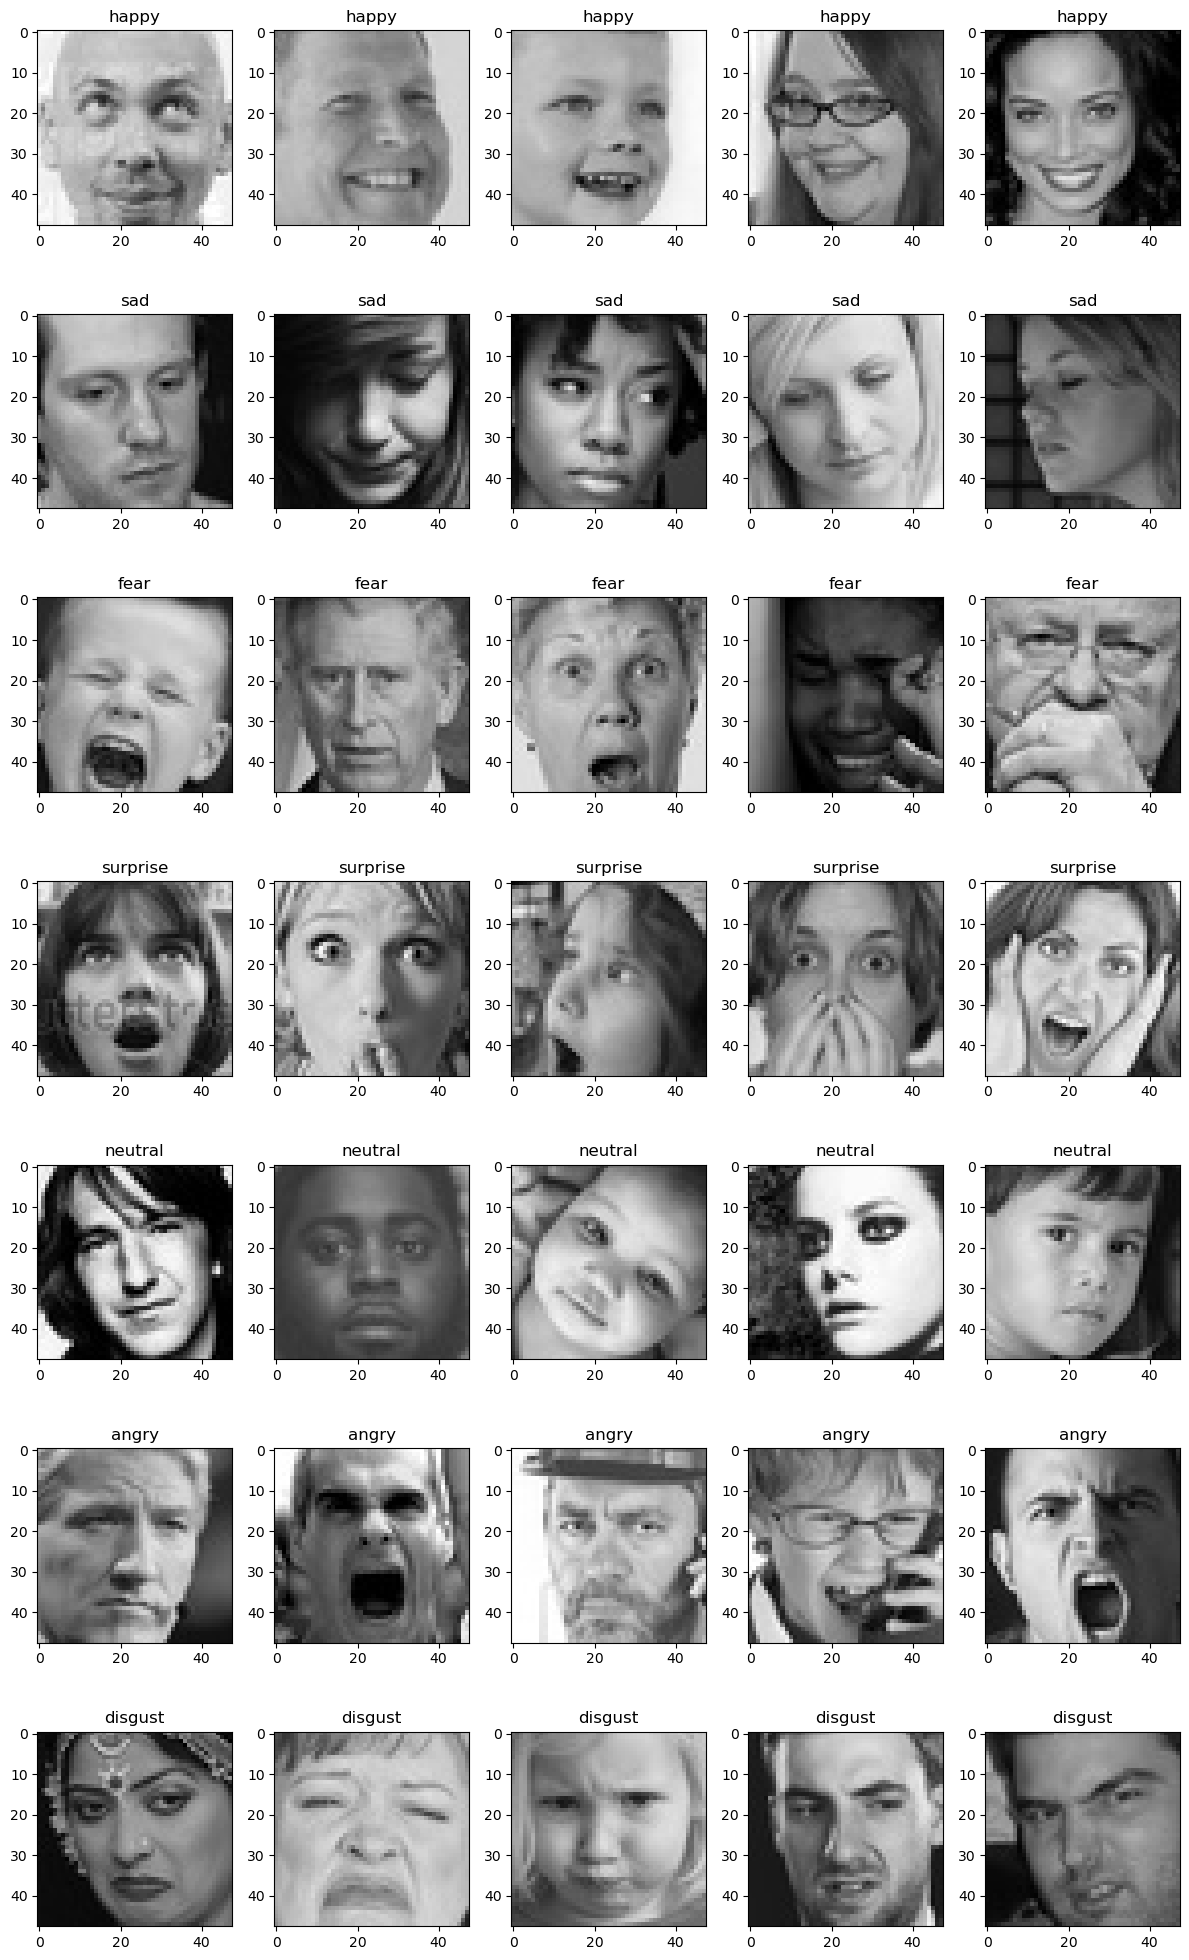

In [6]:
def show_sample_images():
    plt.figure(0, figsize=(12,20))
    cpt = 0

    for expression in os.listdir(training_folder):
        if expression.find('.') != -1:
            continue
        images_files = glob.glob(training_folder+ expression + '/*.jpg')
        for i in range(1,6):
            cpt = cpt + 1
            plt.subplot(7,5,cpt)
            img = load_img(images_files[i], target_size=(images_size, images_size))
            plt.imshow(img, cmap="gray")
            plt.title(expression)

    plt.tight_layout()
    plt.show()

show_sample_images()

### Examples of images that can present issues

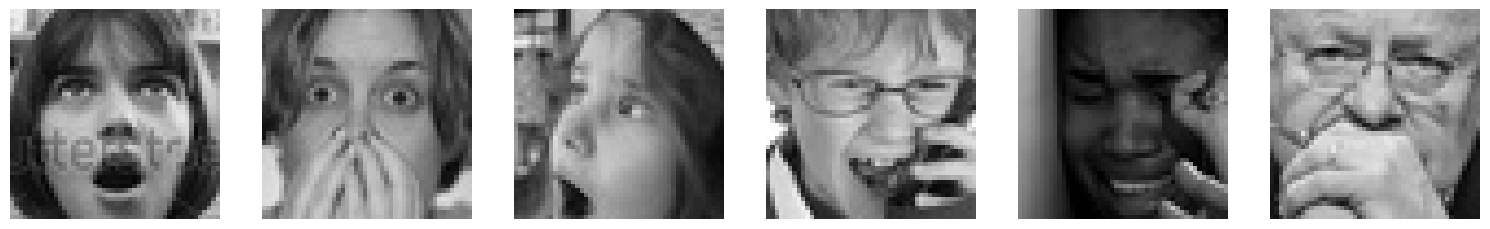

In [7]:
def show_sample_with_issues():

    images = [
        'surprise/15259.jpg',
        'surprise/4571.jpg',
        'surprise/17328.jpg',
         'angry/30797.jpg',
         'fear/12244.jpg',
         'fear/189.jpg',

    ]

    plt.figure(0, figsize=(15,12))
    cpt = 0

    for i,image in enumerate(images):
            plt.subplot(1,6,i+1)
            img = load_img(training_folder + image, target_size=(images_size, images_size))
            plt.imshow(img, cmap="gray")
            plt.tight_layout()
            plt.axis('off')


    plt.show()

show_sample_with_issues()

#### Check classes' Balance

In [8]:
def count_images(folder):
    result = dict()
    for expression in os.listdir(folder):
        if expression.find('.') != -1:
            continue
        images_files = glob.glob(folder + expression + '/*.jpg')
        result[expression] = len(images_files)
    return result

def plot_dist(my_dict, title):

    fig, ax = plt.subplots(figsize=(10, 6))

    p = ax.barh(range(len(my_dict)), list(my_dict.values()), align='center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.yticks(range(len(my_dict)), list(my_dict.keys()))
    plt.title(title + ' Distribution')
    plt.bar_label(p, label_type='edge',  padding=1, fontsize=10)
    plt.show()

    
train_count = count_images(training_folder)
testing_count = count_images(testing_folder)

print('Training', train_count)
print('Testing', testing_count)


Training {'happy': 7164, 'sad': 4938, 'fear': 4103, 'surprise': 3205, 'neutral': 4982, 'angry': 3993, 'disgust': 436}
Testing {'happy': 1825, 'sad': 1139, 'fear': 1018, 'surprise': 797, 'neutral': 1216, 'angry': 960, 'disgust': 111}


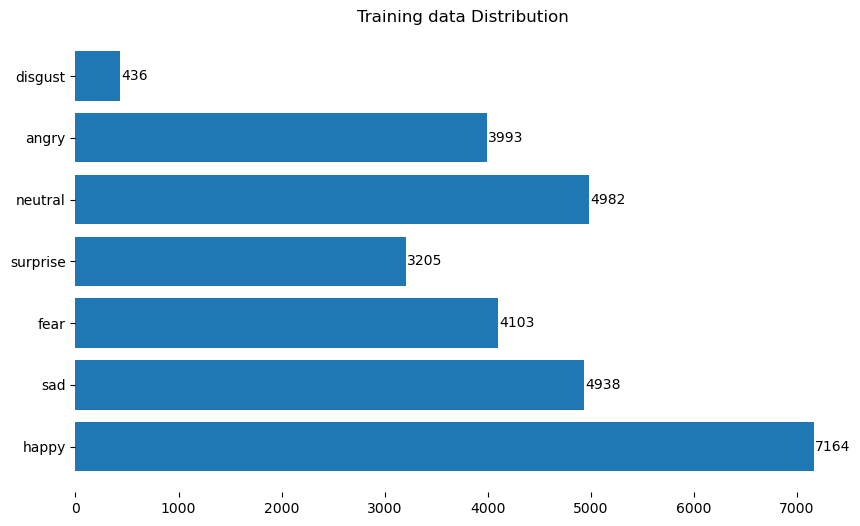

In [9]:
plot_dist(train_count, "Training data")

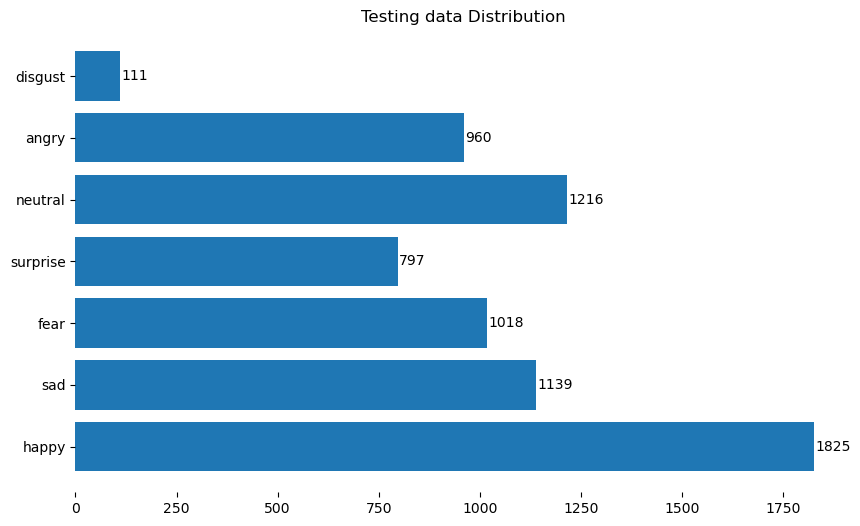

In [10]:
plot_dist(testing_count, "Testing data")

#### Import files

In [11]:
color_mode='grayscale'
default_batch_size=32
crop_to_aspect_ratio=True
label_mode='categorical'
shuffle_train=True


In [12]:
ds_train = image_dataset_from_directory(training_folder, 
                                        image_size=(images_size, images_size),
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=default_batch_size,
                                        label_mode=label_mode,
                                        shuffle=shuffle_train,
                                        seed=global_seed)

ds_test = image_dataset_from_directory(testing_folder, 
                                       image_size=(images_size, images_size),
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=default_batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=False,
                                       seed=global_seed)

Found 28821 files belonging to 7 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-12 01:04:49.342785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-12 01:04:49.342808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 7066 files belonging to 7 classes.


### PreProcessing - Data augmentation

No need for resizing or normalizing. All images are already normalized

In [13]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

In [14]:
fill_mode = 'reflect'

In [15]:
no_data_augmentation = Sequential([
    layers.Rescaling(1./255),
])

data_augmentation = Sequential([
    layers.RandomFlip(mode='horizontal', seed=global_seed),
    layers.RandomRotation((0.05), fill_mode=fill_mode,  seed = global_seed),
    layers.RandomBrightness(factor=0.15)
])

data_augmentation_augmentation_with_rescaling = Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip(mode='horizontal', seed=global_seed),
    layers.RandomRotation((0.05), fill_mode=fill_mode,  seed = global_seed),
    layers.RandomBrightness(factor=0.15)
])

2023-01-12 01:04:49.884451: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


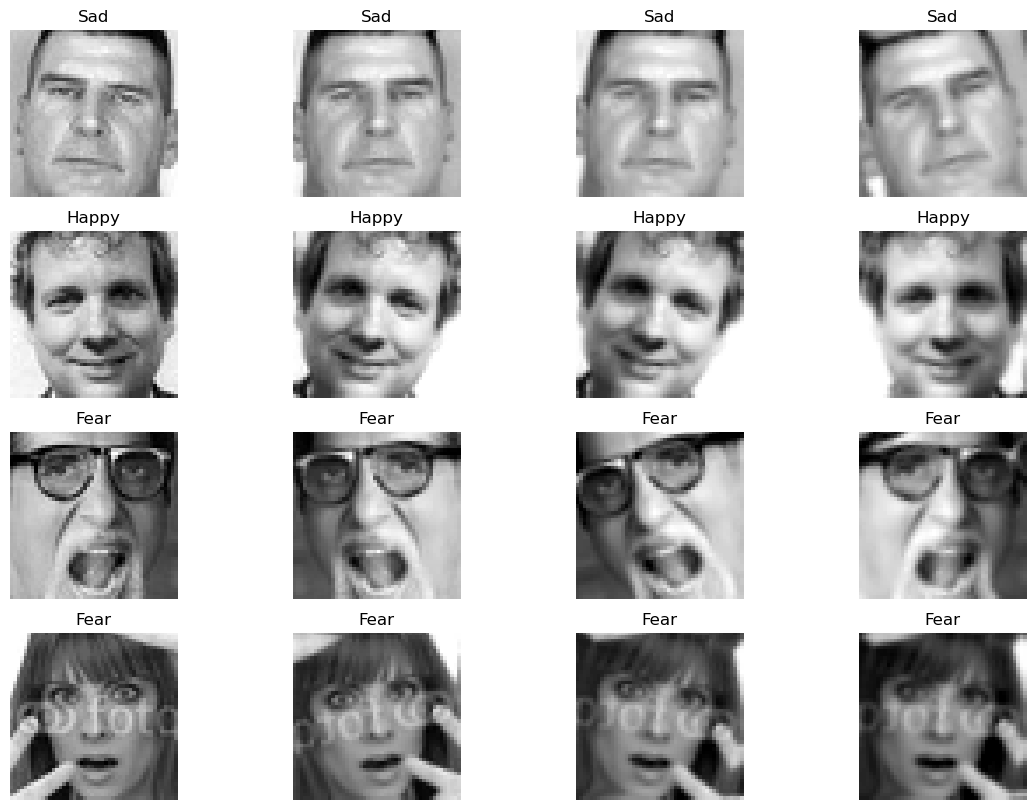

In [16]:
def show_sample_batch(ds, augmentation, grid_size=(4, 4), figsize=(14, 10)):
    n_images = grid_size[0]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(14, 10))
    count = 0
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        img_ = tf.cast(img, tf.int32)

        for j in range(grid_size[1]):
            # Prepare the image
            if j>0:
                img_ = tf.cast(augmentation(img_, training=True), tf.int32)
            ax = plt.subplot(grid_size[0], grid_size[1],  count + 1)        
            plt.imshow(img_, cmap="gray")
            plt.title(class_labels[tf.math.argmax(y)])
            # plt.title("{} image of class \"{}\"".format(img.shape, y), size=6)
            plt.axis("off")
            count+=1

show_sample_batch(ds_train, augmentation=data_augmentation)


### Class Weights

## Base models

In [17]:
default_activation='relu'
default_loss='categorical_crossentropy'
default_metrics = [metrics.CategoricalAccuracy(name='Accuracy')]
default_padding = "same"
default_filter_size = 3
default_maxpooling_size = 2
default_strides = 1
default_batch_normalization = True
default_dropout = 0.2 # from previous studies we already saw that overfitting was an issue
default_learning_rate = 0.001 # default value for Adam
num_classes = 7
default_input_shape = (48,48,1)

### Class weights

In [18]:
# Calculate the class weights
y_train =  np.array([])
for x, y in ds_test:
  y_train = np.concatenate([y_train, np.argmax(y.numpy(), axis=-1)])

class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = {c: cw for c, cw in zip(range(len(class_labels)), class_weight)}
for c, w in class_weight.items():
    print('Weight of class {}: {:.2f}'.format(class_labels[c], w))

Weight of class Angry: 1.05
Weight of class Disgust: 9.09
Weight of class Fear: 0.99
Weight of class Happy: 0.55
Weight of class Neutral: 0.83
Weight of class Sad: 0.89
Weight of class Surprise: 1.27


### Auxiliary functions to help making CNN models

In [19]:
def default_optimizer(learning_rate = default_learning_rate):
    return optimizers.Adam(learning_rate = learning_rate)
    #return optimizers.SGD(learning_rate=learning_rate)
    
def default_initializer():
    return initializers.GlorotNormal(seed=global_seed)
    # return initializers.HeUniform(seed=global_seed)
    # return initializers.HeNormal(seed=global_seed)

def sgd_optimizer(learning_rate = default_learning_rate):
    return optimizers.SGD(learning_rate=learning_rate)

# def he_initializer():
#     

In [20]:
def add_cnn_layer(
    model,
    n_filters,
    n_layers=1,
    size=default_filter_size,
    strides = default_strides,
    maxpooling_size=default_maxpooling_size,
    dropout = default_dropout,
    activation=default_activation,
    padding=default_padding,
    batch_normalization = default_batch_normalization,
    input_shape=default_input_shape,
    kernel_regularizer=None,
    kernel_initializer=default_initializer()
    ):

    for i in range(n_layers):
        if (input_shape is not None) and (i == 0):
            model.add(Conv2D(n_filters,(size,size),strides=(strides,strides), activation=activation, padding=padding,kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer, input_shape=input_shape))
        else:
            model.add(Conv2D(n_filters,(size,size),strides=(strides,strides), activation=activation, padding=padding,kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer))
        
    if batch_normalization:
        model.add(BatchNormalization())
    if maxpooling_size is not None:
        model.add(MaxPooling2D(pool_size=(maxpooling_size,maxpooling_size)))
    if dropout is not None:
        model.add(Dropout(dropout))
    
    return model


In [21]:
def add_dense_layer(
    model,
    size,
    dropout = default_dropout,
    activation=default_activation,
    batch_normalization = default_batch_normalization,
    kernel_initializer=default_initializer(),
    kernel_regularizer=None
    ):
    model.add(Dense(size, activation=activation, kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(BatchNormalization())
    if dropout is not None:
        model.add(Dropout(dropout))
    return model

In [22]:
def model_compile(
    model,
    optimizer=default_optimizer(),
    metrics=default_metrics
):
    model.compile(
        loss = default_loss, 
        optimizer = optimizer,
        metrics = default_metrics)
    return model

In [23]:
def test_models(models_to_test, test_name, epochs=50, batch_size=default_batch_size):
   
    for name, model in models_to_test.items():
        callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir='logs/' + test_name + '/' + name + '/', histogram_freq=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
            tf.keras.callbacks.ModelCheckpoint('best_models/' + test_name + '/' + name + ".h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        ]
        
        history = model.fit(ds_train, validation_data=ds_test, epochs=epochs, verbose=2, class_weight=class_weight, callbacks=[callbacks], batch_size = batch_size)

### Base Models definitions

In [24]:
def model_2cnn_1fc(dropout=default_dropout,kernel_regularizer=None,augmentation=no_data_augmentation):
    model = Sequential()
    if augmentation is not None:
        model.add(augmentation)
    add_cnn_layer(model, n_filters=64, input_shape=(48,48,1),dropout=dropout)
    add_cnn_layer(model, n_filters=128,dropout=dropout,kernel_regularizer=kernel_regularizer)
    model.add(Flatten())
    add_dense_layer(model, size=256,dropout=dropout)
    model.add(Dense(num_classes,activation="softmax"))
    return model

print(model_2cnn_1fc(augmentation=None).summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)     

In [25]:
def model_3cnn_2fc(dropout=default_dropout,kernel_regularizer=None,augmentation=no_data_augmentation,):
    kernel_regularizer_1 = None
    kernel_regularizer_2 = None
    kernel_regularizer_3 = kernel_regularizer
    model = Sequential()
    if augmentation is not None:
        model.add(augmentation)
    add_cnn_layer(model, n_filters=64, input_shape=(48,48,1),kernel_regularizer=kernel_regularizer_1)
    add_cnn_layer(model, n_filters=128,dropout=dropout,kernel_regularizer=kernel_regularizer_2)
    add_cnn_layer(model, n_filters=256,dropout=dropout,kernel_regularizer=kernel_regularizer_3)
    model.add(Flatten())
    add_dense_layer(model, size=256,dropout=dropout)
    add_dense_layer(model, size=512,dropout=dropout)
    model.add(Dense(num_classes,activation="softmax"))
    return model

print(model_3cnn_2fc(augmentation=None).summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 24, 24, 128)     

In [26]:
def model_4cnn_2fc(dropout=default_dropout,kernel_regularizer=None,augmentation=no_data_augmentation,):
    kernel_regularizer_1 = None
    kernel_regularizer_2 = None
    kernel_regularizer_3 = None
    kernel_regularizer_4 = kernel_regularizer
    model = Sequential()
    if augmentation is not None:
        model.add(augmentation)
    add_cnn_layer(model, n_filters=64, input_shape=(48,48,1),dropout=dropout,kernel_regularizer=None)
    add_cnn_layer(model, n_filters=128,dropout=dropout,kernel_regularizer=kernel_regularizer_2)
    add_cnn_layer(model, n_filters=256,dropout=dropout,kernel_regularizer=kernel_regularizer_4)
    add_cnn_layer(model, n_filters=512,dropout=dropout,kernel_regularizer=kernel_regularizer_4)
    model.add(Flatten())
    add_dense_layer(model, size=256)
    add_dense_layer(model, size=512)
    model.add(Dense(num_classes,activation="softmax"))
    return model

print(model_4cnn_2fc(augmentation=None).summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_9 (Batc  (None, 24, 24, 128)     

In [27]:
def model_vgg13(dropout=default_dropout,kernel_regularizer=None,augmentation=no_data_augmentation,):

    kernel_regularizer_1 = None
    kernel_regularizer_2 = None
    kernel_regularizer_3 = None
    kernel_regularizer_4 = None
    kernel_regularizer_5 = kernel_regularizer

    model = Sequential()
    if augmentation is not None:
        model.add(augmentation)
    
    add_cnn_layer(model, n_layers=2, n_filters=64, input_shape=(48,48,1),dropout=dropout,kernel_regularizer=kernel_regularizer_1)
    add_cnn_layer(model, n_layers=2, n_filters=128,dropout=dropout,kernel_regularizer=kernel_regularizer_2)
    add_cnn_layer(model, n_layers=2, n_filters=256,dropout=dropout,kernel_regularizer=kernel_regularizer_3)
    add_cnn_layer(model, n_layers=2, n_filters=512,dropout=dropout,kernel_regularizer=kernel_regularizer_4)
    add_cnn_layer(model, n_layers=2, n_filters=512,dropout=dropout,kernel_regularizer=kernel_regularizer_5)

    model.add(Flatten())

    add_dense_layer(model, size=4096,dropout=dropout)
    add_dense_layer(model, size=4096,dropout=dropout)
    
    model.add(Dense(num_classes,activation="softmax"))

    #1st simulation had regulizers on dense layers

    return model

print(model_vgg13(augmentation=None).summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_14 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 128)      

## Base Models testing

In [28]:
# %load_ext tensorboard
# %tensorboard --logdir logs/initial_tests

In [29]:
models_to_test = {
   '2cnn_1fc':  model_compile(model_2cnn_1fc(dropout=None)),
   '3cnn_2fc':  model_compile(model_3cnn_2fc(dropout=None)),
   '4cnn_2fc':  model_compile(model_4cnn_2fc(dropout=None)),
   'vgg13':  model_compile(model_vgg13(dropout=None)),
}

# test_models(models_to_test, test_name='initial_tests', epochs=50)


Try to reduce overfitting

In [30]:
models_to_test = {
   '2cnn_1fc_dropout_2':  model_compile(model_2cnn_1fc(dropout=0.2)),
   '2cnn_1fc_dropout_2_l2':  model_compile(model_2cnn_1fc(dropout=0.2, kernel_regularizer=regularizers.L2(l2=0.01))),
   '3cnn_2fc_dropout_2':  model_compile(model_3cnn_2fc(dropout=0.2)),
   '3cnn_2fc_dropout_2_l2':  model_compile(model_3cnn_2fc(dropout=0.2, kernel_regularizer=regularizers.L2(l2=0.01))),
   '4cnn_2fc_dropout_2':  model_compile(model_4cnn_2fc(dropout=0.3)),
   '4cnn_2fc_dropout_2_l2':  model_compile(model_4cnn_2fc(dropout=0.2, kernel_regularizer=regularizers.L2(l2=0.01))),
   'vgg13_dropout_2':  model_compile(model_vgg13(dropout=0.2)),
   'vgg13_dropout_2_l2':  model_compile(model_vgg13(dropout=0.2, kernel_regularizer=regularizers.L2(l2=0.01))),
}
# test_models(models_to_test, test_name='initial_tests', epochs=50)

## KerasTuner - find an alternative architecture 

In [31]:
def model_KT(parameters):

  A = parameters.Int('input_units', min_value=32, max_value=512, step=32) 
  B = parameters.Int('n_layers', min_value=1, max_value=4, step=1)
  D = parameters.Int('n_dense_layers', min_value=1, max_value=3, step=1)

  model_KT = Sequential()

  model_KT.add(Conv2D(filters = A, kernel_size =(3,3), padding="same", input_shape=(48,48,1)))
  model_KT.add(BatchNormalization())
  model_KT.add(Activation("relu"))
  model_KT.add(MaxPooling2D(pool_size=(2,2)))
  model_KT.add(Dropout(0.25))

  for i in range(B):

    C = parameters.Int(f'conv_{i}_units', min_value=32, max_value=512, step=32)

    model_KT.add(Conv2D(filters = C, kernel_size =(3,3), padding="same"))
    model_KT.add(BatchNormalization())
    model_KT.add(Activation("relu"))
    model_KT.add(MaxPooling2D(pool_size=(2,2)))
    model_KT.add(Dropout(0.25))

  model_KT.add(Flatten())

  for j in range(D):

    E = parameters.Int(f'dense_{j}_units', min_value=480, max_value=640, step=32)

    model_KT.add(Dense(E, activation = "relu"))
    model_KT.add(Dropout(0.25))

  model_KT.add(Dense(7, activation = 'softmax'))

  model_KT.compile(
      loss = default_loss, 
      optimizer = optimizers.Adam(learning_rate = default_learning_rate),
      metrics = default_metrics)
  
  return model_KT 
  

def run_keras_tuner_model():
  
  tuner = RandomSearch(
      model_KT,
      max_trials= 50,
      overwrite=True, 
      objective="val_Accuracy", 
      )

  name = 'model_KT'

  callbacks = [
      tf.keras.callbacks.TensorBoard(log_dir='logs/kt_arch/' + name + '/', histogram_freq=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
  ]
  tuner.search(ds_train, validation_data=ds_test, epochs=20, verbose=2, callbacks=callbacks)
  tuner.get_best_models()[0].summary()  
  tuner.get_best_hyperparameters()[0].values


# run_keras_tuner_model()

##### Construct the best model returned by KT

In [32]:
def model_best_kt(dropout=default_dropout,kernel_regularizer=None,augmentation=no_data_augmentation,):
    kernel_regularizer_1 = None
    kernel_regularizer_2 = None
    kernel_regularizer_3 = None
    kernel_regularizer_4 = None
    model = Sequential()
    if augmentation is not None:
        model.add(augmentation)
    add_cnn_layer(model, n_filters=352, input_shape=(48,48,1),dropout=dropout,kernel_regularizer=kernel_regularizer_1)
    add_cnn_layer(model, n_layers=2, n_filters=96,dropout=dropout,kernel_regularizer=kernel_regularizer_2)
    add_cnn_layer(model, n_filters=416,dropout=dropout,kernel_regularizer=kernel_regularizer_3)
    add_cnn_layer(model, n_filters=160,dropout=dropout,kernel_regularizer=kernel_regularizer_4)
    model.add(Flatten())
    add_dense_layer(model, size=576)
    add_dense_layer(model, size=640)
    add_dense_layer(model, size=512)
    model.add(Dense(num_classes,activation="softmax"))
    return model

print(model_best_kt(augmentation=None).summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 48, 48, 352)       3520      
                                                                 
 batch_normalization_84 (Bat  (None, 48, 48, 352)      1408      
 chNormalization)                                                
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 24, 24, 352)      0         
 g2D)                                                            
                                                                 
 dropout_66 (Dropout)        (None, 24, 24, 352)       0         
                                                                 
 conv2d_77 (Conv2D)          (None, 24, 24, 96)        304224    
                                                                 
 conv2d_78 (Conv2D)          (None, 24, 24, 96)      

## KerasTuner - hyperparameters test

In [33]:
def model_4cnn_2fc_KT(parameters):
  learning_rate = parameters.Float("learning_rate", min_value=0.001, max_value=0.01, step=0.001)
  dropout_rate = parameters.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.25, step=0.05)
  kernel_regularizer = parameters.Float("kernel_regularizer", min_value=0.0001, max_value=0.01, step=0.01)

  no_of_classes = 7

  model = model_compile(
    model_4cnn_2fc(
      dropout=dropout_rate,
      kernel_regularizer=regularizers.L2(l2=kernel_regularizer)
      ),
      optimizer=default_optimizer(learning_rate=learning_rate)
  )
  return model


def run_model_4cnn_2fc_KT():

  tuner = RandomSearch( 
    model_4cnn_2fc_KT,
    max_trials=50,
    overwrite=True, 
    objective="val_Accuracy", 
    )


  name = 'model_4cnn_2fc_KT'

  callbacks = [
      tf.keras.callbacks.TensorBoard(log_dir='logs/kt_hyper/' + name + '/', histogram_freq=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
  ]
  tuner.search(ds_train, validation_data=ds_test, epochs=20, verbose=2, callbacks=callbacks)
  tuner.get_best_models()[0]

# run_model_4cnn_2fc_KT()

In [34]:
def model_vgg13_KT(parameters):
  learning_rate = parameters.Float("learning_rate", min_value=0.001, max_value=0.01, step=0.001)
  dropout_rate = parameters.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.25, step=0.05)
  kernel_regularizer = parameters.Float("kernel_regularizer", min_value=0.0001, max_value=0.01, step=0.01)

  no_of_classes = 7

  model = model_compile(
    model_vgg13(
      dropout=dropout_rate,
      kernel_regularizer=regularizers.L2(l2=kernel_regularizer)
      ),
      optimizer=default_optimizer(learning_rate=learning_rate)
  )
  return model

def run_model_vgg13_KT():

  tuner = RandomSearch(
    model_vgg13_KT,
    max_trials=50,
    overwrite=True, 
    objective="val_Accuracy", 
    )

  name = 'model_vgg13_KT'

  callbacks = [
      tf.keras.callbacks.TensorBoard(log_dir='logs/kt_hyper/' + name + '/', histogram_freq=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
  ]
  tuner.search(ds_train, validation_data=ds_test, epochs=20, verbose=2, callbacks=callbacks)
  tuner.get_best_models()[0]

In [35]:
def model_best_kt(parameters):
  learning_rate = parameters.Float("learning_rate", min_value=0.001, max_value=0.01, step=0.001)
  dropout_rate = parameters.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.25, step=0.05)
  kernel_regularizer = parameters.Float("kernel_regularizer", min_value=0.0001, max_value=0.01, step=0.01)

  no_of_classes = 7

  model = model_compile(
    model_best_kt(
      dropout=dropout_rate,
      kernel_regularizer=regularizers.L2(l2=kernel_regularizer)
      ),
      optimizer=default_optimizer(learning_rate=learning_rate)
  )
  return model

def run_model_best_kt():

  tuner = RandomSearch(
      model_vgg13_KT,
      max_trials=50,
      overwrite=True, 
      objective="val_Accuracy",
      )

  name = 'model_best_kt'

  callbacks = [
      tf.keras.callbacks.TensorBoard(log_dir='logs/kt_hyper/' + name + '/', histogram_freq=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
  ]
  tuner.search(ds_train, validation_data=ds_test, epochs=20, verbose=2, callbacks=callbacks)
  tuner.get_best_models()[0]

## More hyperparameters tests

In [36]:
models_to_test = {
    '4cnn_2fc_sgd':  model_compile(model_4cnn_2fc(dropout=None), optimizer=sgd_optimizer()),
    '4cnn_2fc_dropout_3_sgd':  model_compile(model_4cnn_2fc(dropout=0.3), optimizer=sgd_optimizer()),
    '4cnn_2fc_dropout_3_l2_sgd':  model_compile(model_4cnn_2fc(dropout=0.3, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer()),
    'vgg13_sgd':  model_compile(model_vgg13(dropout=None), optimizer=sgd_optimizer()),
    'vgg13_dropout_3_sgd':  model_compile(model_vgg13(dropout=0.3), optimizer=sgd_optimizer()),
    'vgg13_dropout_3_l2_sgd':  model_compile(model_vgg13(dropout=0.3, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer()),
    'model_best_kt__sgd':  model_compile(model_vgg13(dropout=None), optimizer=sgd_optimizer()),
    'model_best_kt_dropout_3_sgd':  model_compile(model_vgg13(dropout=0.3), optimizer=sgd_optimizer()),
    'model_best_kt_dropout_3_l2_sgd':  model_compile(model_vgg13(dropout=0.3, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer()),
}

#test_models(models_to_test, test_name='initial_tests', epochs=150, batch_size=16)


In [37]:
#test_models(models_to_test, test_name='initial_tests', epochs=150, batch_size=64)


In [38]:
#test_models(models_to_test, test_name='initial_tests', epochs=150, batch_size=256)

In [39]:
models_to_test = {
    '4cnn_2fc_dropout_4_l201_sgd_01_150epochs_he_batch_256_10':  model_compile(model_4cnn_2fc(dropout=0.3, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer(learning_rate=0.008)), 
    '4cnn_2fc_dropout_4_l201_sgd_01_150epochs_he_batch_256_10':  model_compile(model_4cnn_2fc(dropout=0.35, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer(learning_rate=0.008)),
    '4cnn_2fc_dropout_4_l201_sgd_01_150epochs_he_batch_256_10':  model_compile(model_4cnn_2fc(dropout=0.4, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer(learning_rate=0.008)), 
    '4cnn_2fc_dropout_4_l201_sgd_01_150epochs_he_batch_256_10':  model_compile(model_4cnn_2fc(dropout=0.3, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer(learning_rate=0.01)), 
    '4cnn_2fc_dropout_4_l201_sgd_01_150epochs_he_batch_256_10':  model_compile(model_4cnn_2fc(dropout=0.35, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer(learning_rate=0.01)),
    '4cnn_2fc_dropout_4_l201_sgd_01_150epochs_he_batch_256_10':  model_compile(model_4cnn_2fc(dropout=0.4, kernel_regularizer=regularizers.L2(l2=0.01)), optimizer=sgd_optimizer(learning_rate=0.01)), 
}


In [40]:

#test_models(models_to_test, test_name='initial_tests', epochs=150, batch_size=128)

In [41]:

#test_models(models_to_test, test_name='initial_tests', epochs=150, batch_size=256)

## Choosen model evaluation

In [42]:
best_model_file  = models_folder + '4cnn_2fc_dropout_4_l201_sgd_01_150epochs_he_batch_256_10.h5'

In [43]:
model = load_model(best_model_file)

y_real =  np.array([])
predictions = np.array([])
for x, y in ds_test:
  y_real = np.concatenate([y_real, np.argmax(y.numpy(), axis=-1)])
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  

1/1 [==============================] - 0s 16ms/step


2023-01-12 01:04:53.855691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 169ms/step


2023-01-12 01:05:02.966018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [44]:
results_test = model.evaluate(ds_test)
print('TEST: The current model achieved a categorical accuracy of {}%!'.format(round(results_test[1]*100,2)))

2023-01-12 01:05:03.362980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


221/221 [==============================] - 5s 22ms/step - loss: 1.2748 - Accuracy: 0.6032 - AUROC: 0.9038
TEST: The current model achieved a categorical accuracy of 60.32%!


In [45]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

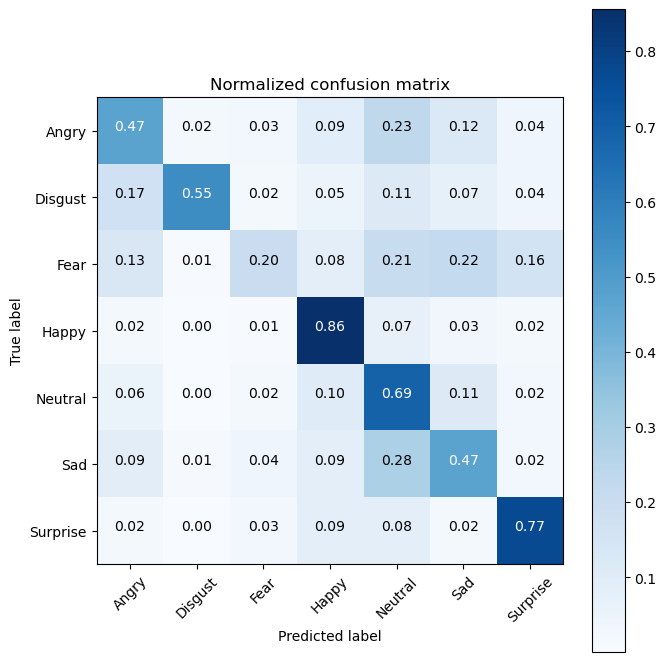

In [46]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_real, predictions)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_labels, title='Normalized confusion matrix')
plt.show()